## Generador de Prediccion Estandar

In [15]:
#Se limpia la memoria
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,734635,39.3,1292120,69.1,1292120,69.1
Vcells,1355888,10.4,79865702,609.4,82311621,628.0


In [16]:
semilla <- 100019
set.seed(semilla)

In [17]:
#cargo las librerias que necesito
require("data.table")
require("rpart")
require("rpart.plot")
#Contiene funciones para evaluar performance de la clasificación
library("ROCR")

In [18]:
setwd("C:/_MCD/Labo1/code")  #Establezco el Working Directory

In [19]:
dataset  <- fread("./datasets/competencia1_2022_FE_combPares.csv")

In [20]:
dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [21]:
modelo  <- rpart(formula=    "clase_ternaria ~ .", #quiero predecir clase_ternaria a partir de el resto de las variables
                 data =      dtrain,  #los datos donde voy a entrenar
                 xval=       0,
                 cp=        -0.709, #esto significa no limitar la complejidad de los splits
                 minsplit= 1414,   #minima cantidad de registros para que se haga el split
                 minbucket=  137,   #tamaño minimo de una hoja
                 maxdepth=  8 )  #PRUEBO  una profundidad de 10

Ahora grafico el arbol, va a ser muy frondoso porque la profundidad es de 10

In [22]:
#prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0)

Ahora aplico al modelo  a los datos muevos  y genero la salida para kaggle

aplico el modelo a los datos nuevos

In [23]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo

prediccion es una matriz con TRES columnas, llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
cada columna es el vector de probabilidades 

agrego a dapply una columna nueva que es la probabilidad de BAJA+2

In [24]:
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]

solo le envio estimulo a los registros con probabilidad de BAJA+2 mayor  a  1/40

In [25]:
head(dapply)

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,⋯,minversion12,tarj_credito_status,tarj_credito_delinquency,tarj_credito_mfinanciacion_limite,dlg2,dlg3,dlg4,dlg5,dlg6,prob_baja2
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
31115668,202103,1,0,0,56,134,688.41,26701.84,98.82,⋯,0,0,0,126684.0,0.7374627,-0.2072046,1,1,184.1434328,0.0003580883
31115678,202103,1,0,0,48,102,78.43,24418.75,-73.62,⋯,0,NA,NA,0.0,-0.7217647,3.7465649,1,1,0.4080392,0.0003580883
31117415,202103,1,0,0,60,55,8101.55,3162.23,13399.50,⋯,0,0,0,126684.0,243.6272727,-2.7542652,1,1,47.9176364,0.0011389838
31117711,202103,1,0,0,46,275,14825.78,138050.05,1146.27,⋯,0,0,0,1041435.4,4.1682545,0.1194800,1,1,1143.0406182,0.0000000000
31118145,202103,1,0,0,47,194,2015.61,31240.49,1791.25,⋯,0,0,0,139352.4,9.2332474,156.1682650,1,1,94.0925773,0.0184352518
31118204,202103,1,0,0,68,260,14424.33,71750.45,3694.07,⋯,0,0,0,354715.2,14.2079615,0.4202348,1,1,-72.2913462,0.0011389838


In [26]:
nrow(dapply)

[1] 162900

In [27]:
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]

In [28]:
fwrite( dapply[,list(numero_de_cliente, Predicted)],
        file= "normal.csv", 
        sep= "," )

creo la carpeta donde va el experimento

In [29]:
#dir.create( "./exp/competencia1" ) 

Hago lo mismo con train para evaluar en entrenamiento

In [30]:
prediccion  <- predict( modelo, dtrain , type = "prob") #aplico el modelo
dtrain[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dtrain[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]

### Curva ROC

In [31]:
dtrain[, clase := 0]
dtrain[ clase_ternaria=='BAJA+2' ,   clase:= 1]

In [32]:
#Calculo las metricas
pred <- prediction(dtrain$Predicted, dtrain$clase)

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
#plot(perf, col=rainbow(10))

#Determino AUC
#performance( pred,"auc")@y.values

### Ganancia

In [33]:
#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Calculo la ganancia
dtrain[  , ganancia:= kFPGain ] #-1250
dtrain[ clase_ternaria=='BAJA+2' ,   ganancia:= kTPGain] #48750
sum( dtrain$ganancia )

gan <- sum( dtrain[ dtrain$Predicted==1, ganancia] )

#TP
truepositive <- sum(dtrain$Predicted*dtrain[,clase])

#Incentivados Totales
incentivados <- sum(dtrain$Predicted)

print(paste("La Ganancia es:", gan))
print(paste("TP:", truepositive))
print(paste("Incentivados:",incentivados))

[1] -254684000

[1] "La Ganancia es: 22674000"
[1] "TP: 482"
[1] "Incentivados: 7943"


grabo el dataset

In [34]:
nombre_archivo_salida <- "./exp/competencia1/inicial.csv"

In [35]:
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= nombre_archivo_salida, 
        sep= "," )

In [36]:
options(scipen=999)

In [37]:
modelo

n= 161342 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 161342 1514 CONTINUA (0.0041154814 0.0052683120 0.9906162066)  
    2) ctrx_quarter< 13.5 8400  711 CONTINUA (0.0347619048 0.0498809524 0.9153571429)  
      4) mcuentas_saldo< -1256.1 2928  416 CONTINUA (0.0618169399 0.0802595628 0.8579234973)  
        8) cprestamos_personales< 1.5 2328  396 CONTINUA (0.0743127148 0.0957903780 0.8298969072)  
         16) cdescubierto_preacordado< 0.5 321  116 CONTINUA (0.1713395639 0.1900311526 0.6386292835) *
         17) cdescubierto_preacordado>=0.5 2007  280 CONTINUA (0.0587942202 0.0807174888 0.8604882910)  
           34) mpasivos_margen< 8.05 1339  221 CONTINUA (0.0634802091 0.1015683346 0.8349514563) *
           35) mpasivos_margen>=8.05 668   59 CONTINUA (0.0494011976 0.0389221557 0.9116766467) *
        9) cprestamos_personales>=1.5 600   20 CONTINUA (0.0133333333 0.0200000000 0.9666666667) *
      5) mcuentas_saldo>=-1256.1 5472  295 CONTINUA (0.020

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


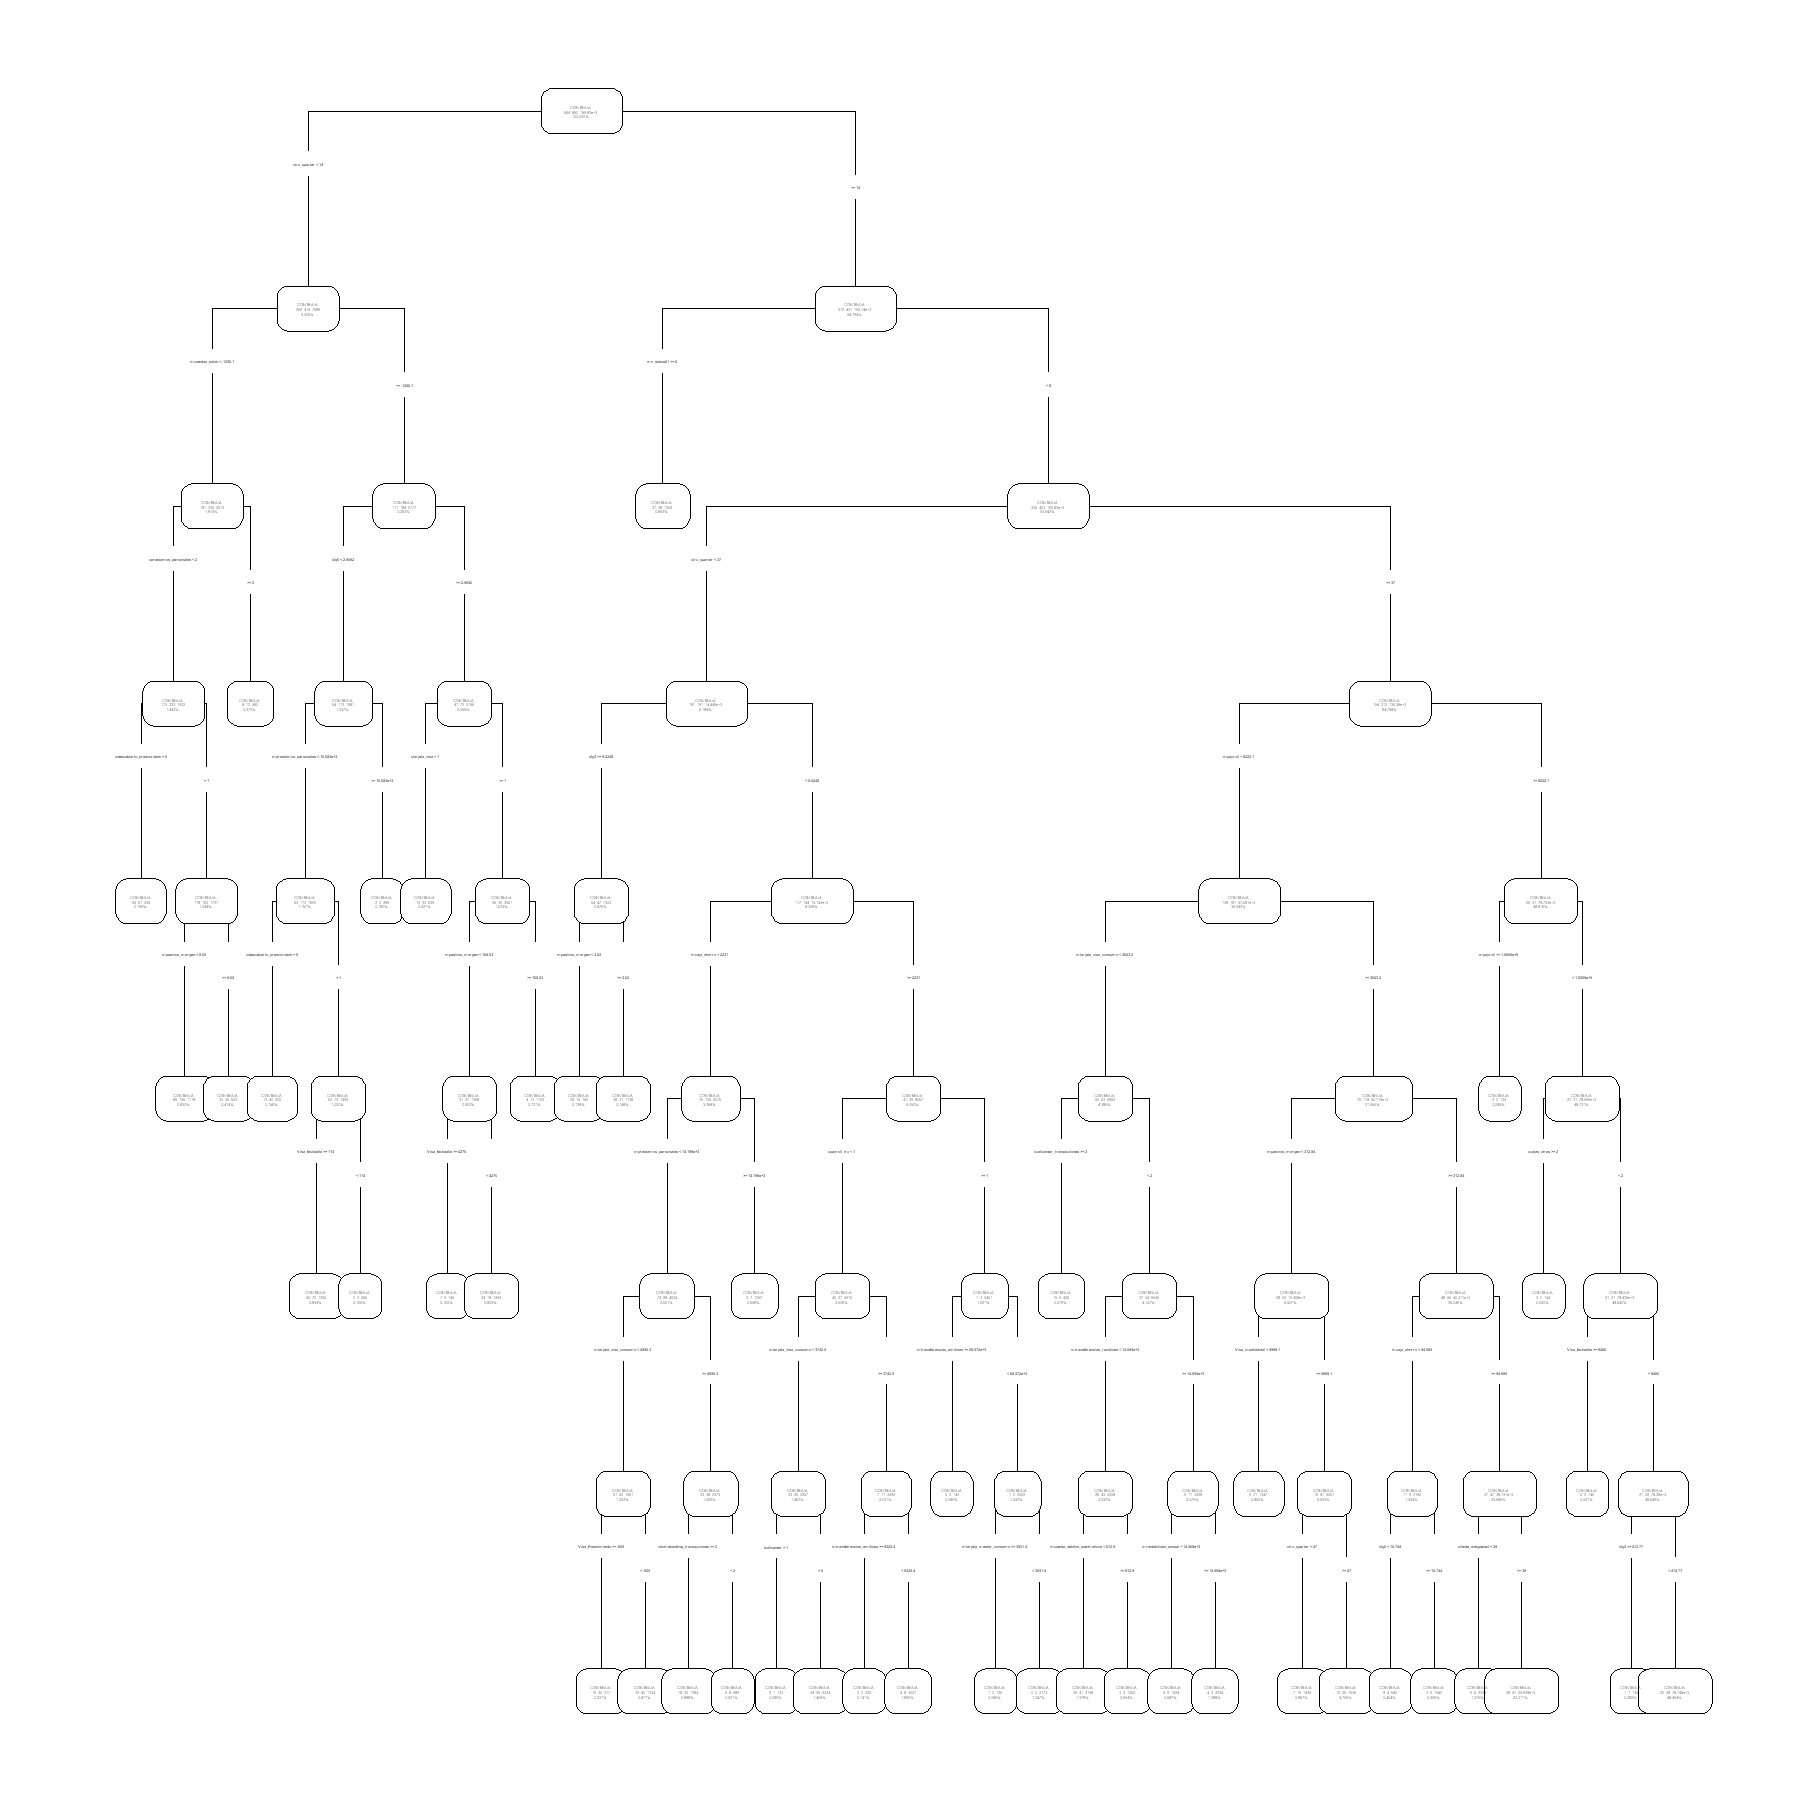

In [38]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [39]:
names(modelo$variable.importance)

[1] "ctrx_quarter"                        
 [2] "mcuentas_saldo"                      
 [3] "cdescubierto_preacordado"            
 [4] "dlg6"                                
 [5] "active_quarter"                      
 [6] "mcuenta_corriente"                   
 [7] "cprestamos_personales"               
 [8] "mprestamos_personales"               
 [9] "mv_status01"                         
[10] "tarj_credito_status"                 
[11] "ccomisiones_otras"                   
[12] "mcaja_ahorro"                        
[13] "dlg3"                                
[14] "mpasivos_margen"                     
[15] "mactivos_margen"                     
[16] "mtarjeta_visa_consumo"               
[17] "dlg4"                                
[18] "tcuentas"                            
[19] "ctarjeta_visa_transacciones"         
[20] "cproductos"                          
[21] "Visa_msaldopesos"                    
[22] "Visa_msaldototal"                    
[23] "Visa_fechaalta"                      
[24] "Visa_Fvencimiento"                   
[25] "tarj_credito_mfinanciacion_limite"   
[26] "dlg5"                                
[27] "cliente_antiguedad"                  
[28] "ctarjeta_visa"                       
[29] "mrentabilidad_annual"                
[30] "Visa_mpagominimo"                    
[31] "ccallcenter_transacciones"           
[32] "mpayroll"                            
[33] "cpayroll_trx"                        
[34] "tcallcenter"                         
[35] "Master_fechaalta"                    
[36] "mrentabilidad"                       
[37] "mttarjeta_visa_debitos_automaticos"  
[38] "ctarjeta_visa_debitos_automaticos"   
[39] "Master_Fvencimiento"                 
[40] "internet"                            
[41] "mcuenta_debitos_automaticos"         
[42] "ctarjeta_master"                     
[43] "mtransferencias_recibidas"           
[44] "numero_de_cliente"                   
[45] "ccomisiones_mantenimiento"           
[46] "mcomisiones_mantenimiento"           
[47] "mcomisiones_otras"                   
[48] "mcomisiones"                         
[49] "ctransferencias_recibidas"           
[50] "mtransferencias_emitidas"            
[51] "chomebanking_transacciones"          
[52] "ccuenta_debitos_automaticos"         
[53] "thomebanking"                        
[54] "ccajas_consultas"                    
[55] "ctransferencias_emitidas"            
[56] "dlg2"                                
[57] "mextraccion_autoservicio"            
[58] "cextraccion_autoservicio"            
[59] "cmobile_app_trx"                     
[60] "minversion12"                        
[61] "ccajas_otras"                        
[62] "Visa_mfinanciacion_limite"           
[63] "Visa_mlimitecompra"                  
[64] "mpagomiscuentas"                     
[65] "mplazo_fijo_dolares"                 
[66] "mtarjeta_master_consumo"             
[67] "ctarjeta_master_transacciones"       
[68] "cprestamos_hipotecarios"             
[69] "minversion2"                         
[70] "ctarjeta_debito_transacciones"       
[71] "Visa_msaldodolares"                  
[72] "mttarjeta_master_debitos_automaticos"
[73] "matm_other"                          
[74] "ctarjeta_master_debitos_automaticos" 
[75] "ccajas_depositos"                    
[76] "cliente_edad"                        
[77] "mpayroll2"                           
[78] "ccaja_ahorro"                        
[79] "cpayroll2_trx"                       
[80] "ccheques_depositados"